In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.rcParams["figure.figsize"] = (12, 4)
SEED = 42
np.random.seed(SEED)
file = "merged_5min_spline_interpolated.csv"
         
testday = 1                    
sampleperday = 288            
testdata = testday * sampleperday

In [58]:
WINDOW_NAME = "12"
WINDOW_SAMPLES = 144 

try:
    full_data = pd.read_csv(file)
    full_data["time"] = pd.to_datetime(full_data["time"], utc=True, errors="coerce")
    full_data = full_data.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)
    full_data = full_data.dropna(subset=["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]).reset_index(drop=True)

    print(f"\ntotal samples: {len(full_data)}")
    print(f"date range  : {full_data['time'].min()} to {full_data['time'].max()}")

except FileNotFoundError:
    print(f"ERROR")
    raise
except Exception as e:
    print("errors in load", e)
    raise

# my train and test
train_data = full_data.iloc[:-testdata].reset_index(drop=True) #all row except testdata
test_data = full_data.iloc[-testdata:].reset_index(drop=True)#only test size roe

print(f"train samples: {len(train_data)}")
print(f"test samples : {len(test_data)}")



total samples: 16089
date range  : 2024-11-12 15:40:00+00:00 to 2025-01-07 12:20:00+00:00
train samples: 15801
test samples : 288


In [59]:
def prepare_one_step_dataset(df):
    input_matrix = df[["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]].shift(1)
    input_matrix = input_matrix.iloc[1:].values# dropingmy1strow
    target_vector = df["indoor_temp"].iloc[1:].values
    return input_matrix, target_vector

# train test
train_inputs_np, train_targets_np = prepare_one_step_dataset(train_data)
test_inputs_np, test_targets_np = prepare_one_step_dataset(test_data)

print(f"train{train_inputs_np.shape}")
print(f"test {test_inputs_np.shape}")

train(15800, 4)
test (287, 4)


In [60]:
# usning my robustscaler
input_scaler = RobustScaler()

train_inputs_scaled = input_scaler.fit_transform(train_inputs_np)
test_inputs_scaled = input_scaler.transform(test_inputs_np)

xgb_model = XGBRegressor(
    n_estimators=500,           
    max_depth=4,                
    learning_rate=0.05,         
    subsample=0.8,              
    colsample_bytree=0.8,       
    reg_lambda=1.0,              
    reg_alpha=0.1,              
    random_state=SEED,
    objective="reg:squarederror",
    n_jobs=-1
)

xgb_model.fit(
train_inputs_scaled, 
train_targets_np,
eval_set=[(test_inputs_scaled, test_targets_np)],
verbose=False
)

# prediction
xgb_pred_train = xgb_model.predict(train_inputs_scaled)
xgb_pred_test = xgb_model.predict(test_inputs_scaled)
clamped_r2 = max(-1, min(1, xgb_r2_w))
#metrics 
xgb_mae_full = mean_absolute_error(test_targets_np, xgb_pred_test)
xgb_rmse_full = np.sqrt(mean_squared_error(test_targets_np, xgb_pred_test))
xgb_r2_full = r2_score(test_targets_np, xgb_pred_test)
xgb_train_mae = mean_absolute_error(train_targets_np, xgb_pred_train)

print("\n XGBoost Performance")
print(f"train MAE={xgb_train_mae:.4f} °C")
print(f"test MAE={xgb_mae_full:.4f} °C")
print(f"test RMSE={xgb_rmse_full:.4f} °C")
print(f"test R²={xgb_r2_full:.4f}")


 XGBoost Performance
train MAE=0.3029 °C
test MAE=0.3154 °C
test RMSE=0.5447 °C
test R²=0.7190



model              MAE (°C)     RMSE (°C)    R²      
xgboost            0.3120       0.5096       0.4638495339105526


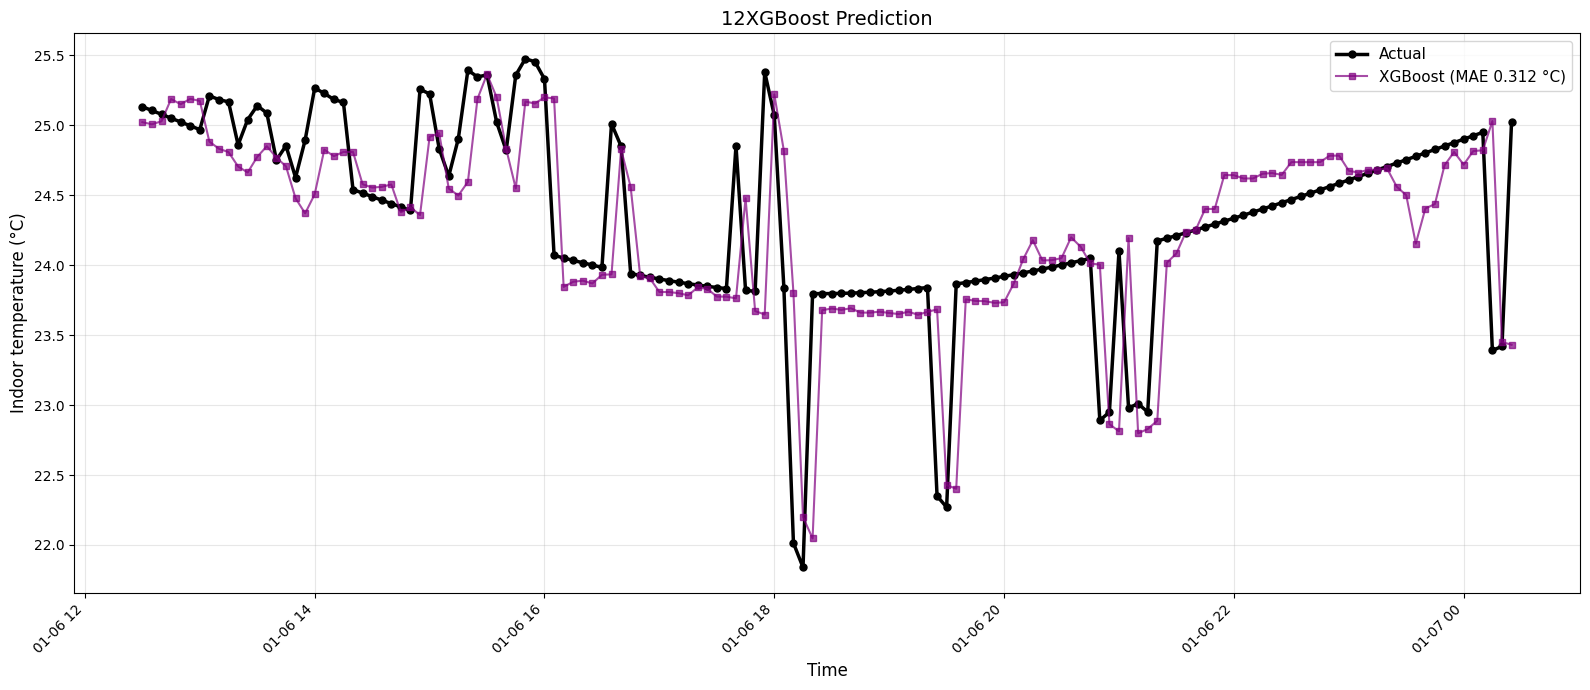


XGBoost Results Summary:
Full test MAE0.3154 °C
MAE0.3120 °C
RMSE0.5096 °C
R² 0.4638


In [61]:

window_size = min(WINDOW_SAMPLES, len(test_targets_np))
xgb_mae_w = mean_absolute_error(test_targets_np[:window_size], xgb_pred_test[:window_size])
xgb_rmse_w = np.sqrt(mean_squared_error(test_targets_np[:window_size], xgb_pred_test[:window_size]))
xgb_r2_w = r2_score(test_targets_np[:window_size], xgb_pred_test[:window_size])

print(f"\n{'model':<18} {'MAE (°C)':<12} {'RMSE (°C)':<12} {'R²':<8}")
print(f"{'xgboost':<18} {xgb_mae_w:<12.4f} {xgb_rmse_w:<12.4f} {max(-1, min(1, xgb_r2_w))}")

#plotnigs
y_true_w = test_targets_np[:window_size]
xgb_pred_w = xgb_pred_test[:window_size]
time_w = test_data["time"].iloc[1:window_size+1].values


plt.figure(figsize=(16, 7))
plt.plot(time_w, y_true_w, "o-", label="Actual", color="black", linewidth=2.5, markersize=5)
plt.plot(time_w, xgb_pred_w, "s-", label=f"XGBoost (MAE {xgb_mae_w:.3f} °C)",color="purple", alpha=0.7, linewidth=1.5, markersize=4)

plt.xlabel("Time", fontsize=12)
plt.ylabel("Indoor temperature (°C)", fontsize=12)
plt.title(f"{WINDOW_NAME.upper()}XGBoost Prediction", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print(f"\nXGBoost Results Summary:")
print(f"Full test MAE{xgb_mae_full:.4f} °C")
print(f"MAE{xgb_mae_w:.4f} °C")
print(f"RMSE{xgb_rmse_w:.4f} °C")
print(f"R² {max(-1, min(1, xgb_r2_w)):.4f}")
